In [1]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
# %load_ext autoreload
# %autoreload 2
%reload_ext autoreload
import imblearn as imb
# print("imblearn version: ",imblearn.__version__)

from sklearn.metrics import confusion_matrix
import itertools

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import sys
sys.path.append('../../')

from sklearn.model_selection import GridSearchCV
from VisUtils import *
from split_data import *
from RF_GSCV import *


# Load binding data 

In [2]:
split_path = '../../../../../data/NEK_data_4Berkeley/NEK2/'
# train_x_df = pd.read_csv(split_path+"/NEK2_binding_random_fold1_trainX.csv")
# train_y_df= pd.read_csv(split_path+"/NEK2_binding_random_fold1_trainY.csv")
# test_x_df= pd.read_csv(split_path+"/NEK2_binding_random_fold1_testX.csv")
# test_y_df= pd.read_csv(split_path+"/NEK2_binding_random_fold1_testY.csv")
# train_x = torch.from_numpy(train_x_df.to_numpy())
# train_y = torch.from_numpy(train_y_df.to_numpy().reshape(-1))
# test_x = torch.from_numpy(test_x_df.to_numpy())
# test_y = torch.from_numpy(test_y_df.to_numpy().reshape(-1))


In [3]:
# # Scale data
# x_df = pd.concat([train_x_df, test_x_df])

# scaling=StandardScaler()
 
# # Use fit and transform method 
# scaling.fit(x_df)
# Scaled_data=scaling.transform(x_df)
# train_x = scaling.transform(train_x_df)
# test_x = scaling.transform(test_x_df) 

# train_y = train_y_df.to_numpy().flatten()
# test_y = test_y_df.to_numpy().flatten()


In [4]:
# back to df for saving 
# train_x_df = pd.DataFrame(train_x) 
# train_y_df = pd.DataFrame(train_y) 
# test_y_df = pd.DataFrame(test_y)
# test_x_df = pd.DataFrame(test_x)

# train_x_df.to_csv(split_path+'bind_train_x_scaledoriginal.csv', index=False, header=False)
# train_y_df.to_csv(split_path+'bind_train_y_scaledoriginal.csv', index=False, header=False) 
# test_y_df.to_csv(split_path+'bind_test_y_scaledoriginal.csv', index=False, header=False) 
# test_x_df.to_csv(split_path+'bind_test_x_scaledoriginal.csv', index=False, header=False) 
# print(train_x_df.shape, train_y_df.shape, test_y_df.shape, test_x_df.shape)


train_x_df = pd.read_csv(split_path+"/bind/bind_train_x_normMorgan2.csv")

train_y_df= pd.read_csv(split_path+"/bind/bind_train_y_normMorgan2.csv")
test_x_df= pd.read_csv(split_path+"/bind/bind_test_x_normMorgan2.csv")
test_y_df= pd.read_csv(split_path+"/bind/bind_test_y_normMorgan2.csv")
train_x = train_x_df.values
train_y = train_y_df.values.reshape(-1)  
test_x = test_x_df.values
test_y = test_y_df.values.reshape(-1)  

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((1124, 2048), (1124,), (282, 2048), (282,))

TRAIN: accuracy: 0.999, precision: 1.000, recall: 0.978, specificity: 1.000
TEST: accuracy: 0.954, precision: 0.429, recall: 0.250, specificity: 0.985


<Figure size 600x400 with 0 Axes>

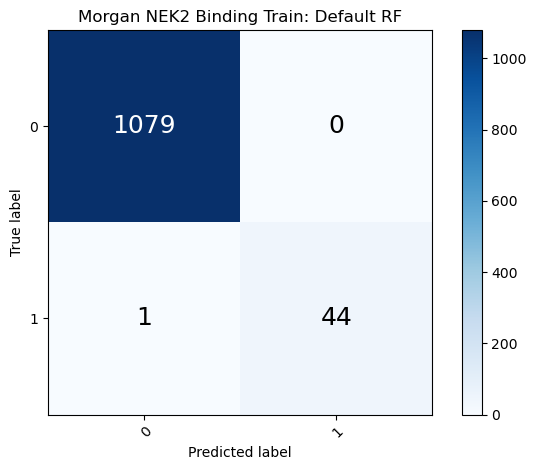

<Figure size 600x400 with 0 Axes>

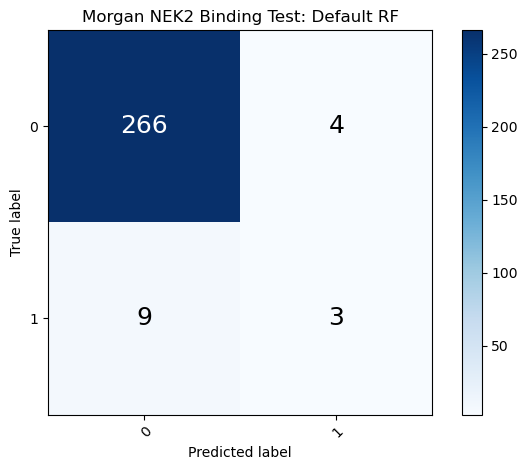

In [5]:
rf_basic100est = rf_models(train_x, train_y, test_x, test_y, 'basic RF', {})
plot_confusion_matrix(train_y, rf_basic100est['train_pred'], ['0','1'], title='Morgan NEK2 Binding Train: Default RF')
plot_confusion_matrix(test_y, rf_basic100est['test_pred'], ['0','1'], title='Morgan NEK2 Binding Test: Default RF')

In [6]:
for param,value in rf_basic100est['model'].get_params().items(): 
    print(f'{param}: {value}')

bootstrap: False
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: 100
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


In [8]:
fn_basic  = (test_y == 1) & (rf_basic100est['test_pred'] == 0)
results_fn  = test_x[fn_basic]
fn_indicies  = np.where(fn_basic)
fn_indicies

(array([270, 273, 274, 275, 276, 278, 279, 280, 281]),)

In [7]:
max_depths = [20,50,100]
n_estimators = [100,200,500]
max_features = [50,100,300]

In [11]:

# rf_plots(train_x, train_y, test_x, test_y, max_depths, n_estimators, max_features, 'basic RF', parameters={}, dataset_type='binding')

# Reduced param grid for grid search - RUN IN BASH SCRIPT 

In [7]:
param_grid = {
    'n_estimators': np.linspace(100, 2000, 3, dtype = int),
    'max_depth': [20, 100, 200, 220],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 5],
    'criterion': ['gini','entropy']
}

In [8]:
save_file = 'atom_nek2bindMorgan2_rf_basic_grid.pkl'
# rf_basicbest = find_best_models(train_x, train_y, test_x, test_y, 'basic RF', {}, param_grid,  3)
# with open(save_file, 'wb') as f:
#     pickle.dump(rf_basicbest['best_model'], f)

TRAIN: accuracy: 0.975, precision: 0.758, recall: 0.556,  specificity: 0.993
TEST: accuracy: 0.957, precision: 0.500, recall: 0.250, specificity: 0.989
bootstrap: False
ccp_alpha: 0.0
class_weight: None
criterion: entropy
max_depth: 100
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 5
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<Figure size 600x400 with 0 Axes>

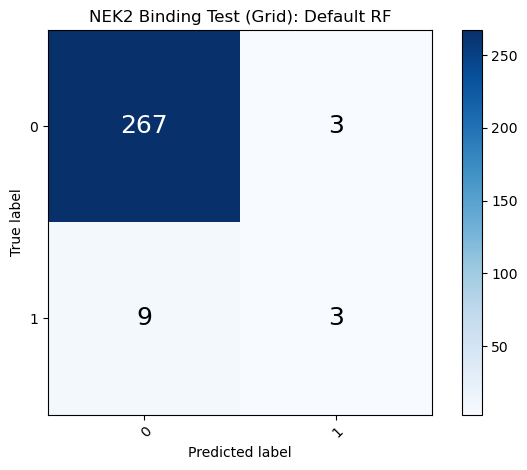

In [9]:
with open('../saved_models/atom_nek2bindMorgan2_rf_basic_grid.pkl', 'rb') as f: 
    rf_basic_best = pickle.load(f) 

results_basic = rf_results2(rf_basic_best, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y,results_basic['test_pred'], ['0','1'], title='NEK2 Binding Test (Grid): Default RF')
for param,value in rf_basic_best.get_params().items(): 
    print(f'{param}: {value}')


# Basic RF + classweight balanced 

TRAIN: accuracy: 0.999, precision: 0.978, recall: 1.000, specificity: 0.999
TEST: accuracy: 0.926, precision: 0.235, recall: 0.333, specificity: 0.952


<Figure size 600x400 with 0 Axes>

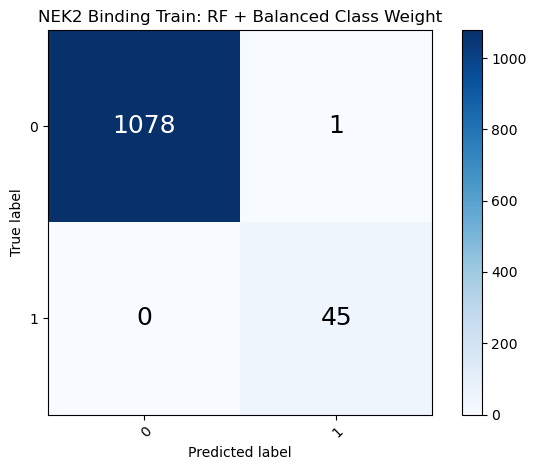

<Figure size 600x400 with 0 Axes>

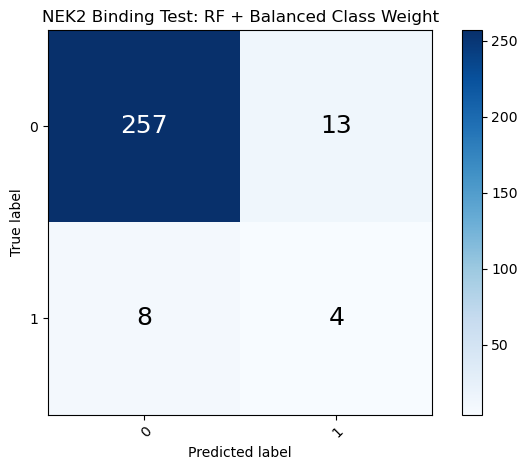

In [8]:
brf_model_BCW = rf_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {})
plot_confusion_matrix(train_y, brf_model_BCW['train_pred'], ['0','1'], title='NEK2 Binding Train: RF + Balanced Class Weight')
plot_confusion_matrix(test_y, brf_model_BCW['test_pred'], ['0','1'], title='NEK2 Binding Test: RF + Balanced Class Weight')

In [14]:
for param,value in brf_model_BCW['model'].get_params().items(): 
    print(f'{param}: {value}')

bootstrap: False
ccp_alpha: 0.0
class_weight: balanced
criterion: gini
max_depth: 100
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


In [6]:
save_file2 = 'atom_nek2bindMorgan2_rf_basicBCW_best.pkl'
# rf_basicBCWbest = find_best_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {}, param_grid, 2)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=1050; total time= 1.1min
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   6.1s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   6.0s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   9.2s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=1050; total time= 1.1min
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=2000; total time= 2.1min
[CV] END criterion=gini, max_depth=20, min_samples_leaf=5, min_samples_split=2, n_estimators=2000; total time= 2.0min
[CV] END criterion=gini, max_depth=20, min_samples_leaf=5, min_samples_split=4, n_estimators=1050; total time= 1.2m

In [9]:
save_file2='atom_nek2bindMorgan2_rf_basicBCW_best.pkl'

# with open(save_file2, 'wb') as f:
#     pickle.dump(rf_basicBCWbest['best_model'], f)

TRAIN: accuracy: 0.991, precision: 0.818, recall: 1.000,  specificity: 0.991
TEST: accuracy: 0.943, precision: 0.357, recall: 0.417, specificity: 0.967
bootstrap: False
ccp_alpha: 0.0
class_weight: balanced
criterion: entropy
max_depth: 200
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 2
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 1050
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


<Figure size 600x400 with 0 Axes>

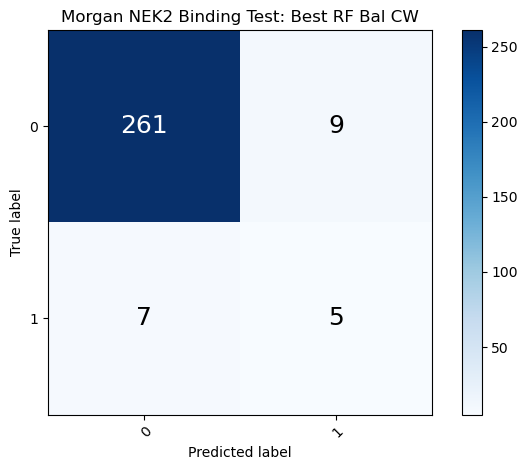

In [10]:
with open('../saved_models/'+'atom_nek2bindMorgan2_rf_basicBCW_best.pkl', 'rb') as f: 
    rf_basicBCWbestmodel = pickle.load(f) 

rf_bcw_results = rf_results2(rf_basicBCWbestmodel, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, rf_bcw_results['test_pred'], ['0','1'], title='Morgan NEK2 Binding Test: Best RF Bal CW')
for param,value in rf_basicBCWbestmodel.get_params().items(): 
    print(f'{param}: {value}')



# Balanced Random Forest Classifier

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.832, precision: 0.192, recall: 1.000, specificity: 0.825
TEST: accuracy: 0.833, precision: 0.143, recall: 0.583, specificity: 0.844


<Figure size 600x400 with 0 Axes>

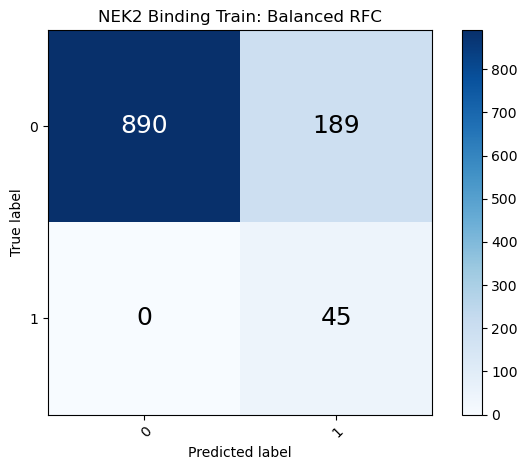

<Figure size 600x400 with 0 Axes>

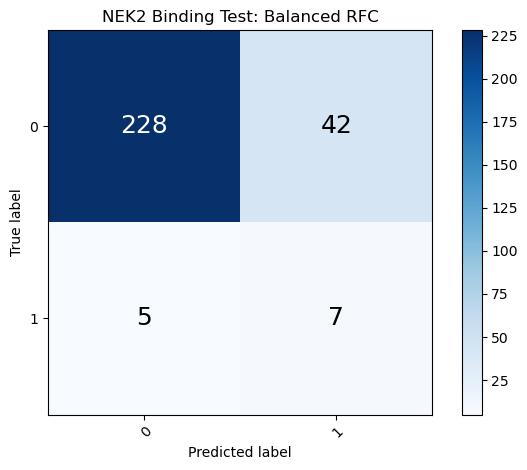

In [12]:
brf_model = rf_models(train_x, train_y, test_x, test_y, 'balanced RF', {})
plot_confusion_matrix(train_y, brf_model['train_pred'], ['0','1'], title='NEK2 Binding Train: Balanced RFC')
plot_confusion_matrix(test_y, brf_model['test_pred'], ['0','1'], title='NEK2 Binding Test: Balanced RFC')

In [26]:
for param,value in brf_model['model'].get_params().items(): 
    print(f'{param}: {value}')

bootstrap: False
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: 100
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


In [11]:
save_file3 = 'atom_nek2bindMorgan_BRFC_best.pkl'
# brfc_best = find_best_models(train_x, train_y, test_x, test_y, 'balanced RF', {}, param_grid, 2)




In [12]:
# with open(save_file3, 'wb') as f:
#     pickle.dump(brfc_best['best_model'], f)

TRAIN: accuracy: 0.843, precision: 0.198, recall: 0.956,  specificity: 0.839
TEST: accuracy: 0.830, precision: 0.140, recall: 0.583, specificity: 0.841
bootstrap: False
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: 220
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 5
min_samples_split: 4
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 2000
n_jobs: None
oob_score: False
random_state: None
replacement: warn
sampling_strategy: warn
verbose: 0
warm_start: False


<Figure size 600x400 with 0 Axes>

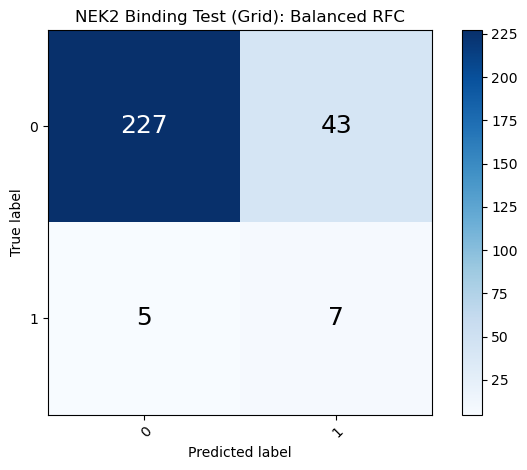

In [13]:
with open('../saved_models/'+save_file3, 'rb') as f: 
    brfc_best = pickle.load(f) 
brfc_results = rf_results2(brfc_best, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, brfc_results['test_pred'], ['0','1'], title='NEK2 Binding Test (Grid): Balanced RFC')
for param,value in brfc_best.get_params().items(): 
    print(f'{param}: {value}')

# Try BRFC with balanced class weight & bootstrap

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 0.378, precision: 0.060, recall: 1.000, specificity: 0.352
TEST: accuracy: 0.369, precision: 0.059, recall: 0.917, specificity: 0.344


<Figure size 600x400 with 0 Axes>

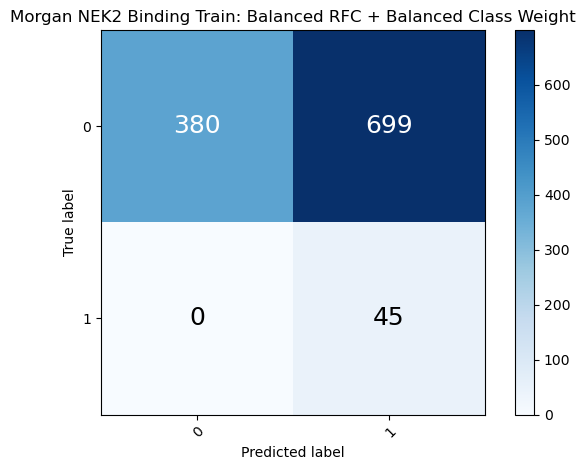

<Figure size 600x400 with 0 Axes>

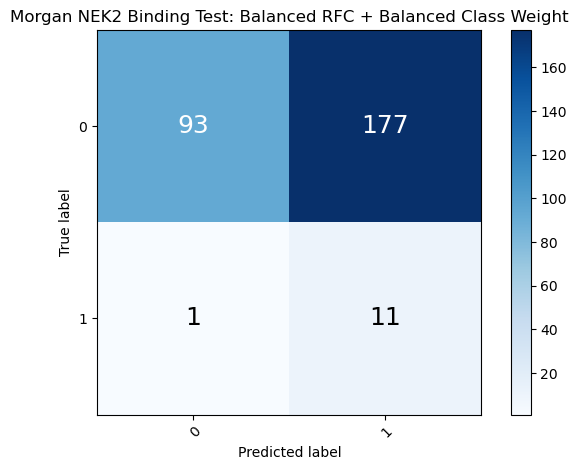

In [19]:
brf_modelCWB = rf_models(train_x, train_y, test_x, test_y, 'balanced RF', {'class_weight':'balanced', 'bootstrap':True})
plot_confusion_matrix(train_y, brf_modelCWB['train_pred'], ['0','1'], title='Morgan NEK2 Binding Train: Balanced RFC + Balanced Class Weight')
plot_confusion_matrix(test_y, brf_modelCWB['test_pred'], ['0','1'], title='Morgan NEK2 Binding Test: Balanced RFC + Balanced Class Weight')

In [20]:
for param,value in brf_modelCWB['model'].get_params().items(): 
    print(f'{param}: {value}')

bootstrap: True
ccp_alpha: 0.0
class_weight: balanced
criterion: gini
max_depth: 100
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
replacement: warn
sampling_strategy: warn
verbose: 0
warm_start: False


In [14]:
save_file4 = 'atom_nek2bindMorgan2_BRFC_BCW_best.pkl'
# brfc_BCW_best = find_best_models(train_x, train_y, test_x, test_y, 'balanced RF', {'class_weight':'balanced', 'bootstrap':True}, param_grid, 2)
# with open(save_file4, 'wb') as f:
#     pickle.dump(brfc_BCW_best['best_model'], f)

TRAIN: accuracy: 0.811, precision: 0.167, recall: 0.933,  specificity: 0.806
TEST: accuracy: 0.823, precision: 0.135, recall: 0.583, specificity: 0.833
bootstrap: False
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: 20
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 5
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
replacement: warn
sampling_strategy: warn
verbose: 0
warm_start: False


<Figure size 600x400 with 0 Axes>

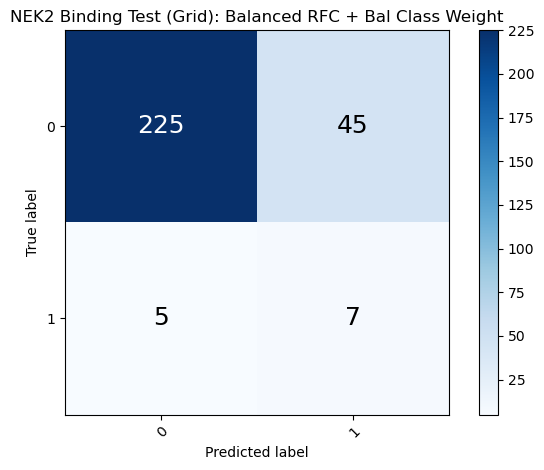

In [15]:

with open('../saved_models/'+save_file4, 'rb') as f: 
    brfc_bcw_best = pickle.load(f) 
brfc_bcw_best_results = rf_results2(brfc_bcw_best, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, brfc_bcw_best_results['test_pred'], ['0','1'], title='NEK2 Binding Test (Grid): Balanced RFC + Bal Class Weight')
for param,value in brfc_bcw_best.get_params().items(): 
    print(f'{param}: {value}')

In [23]:
# max depth was default 1-- 
# temp_nek2bind_MOE_original = {'default_RF':rf_basic100est['model'], 'rf_bcw':brf_model_BCW['model'],
#                               'BRFC': brf_model['model'], 'BRFC_bcw':brf_modelCWB['model']}

# with open('temp_nek2bind_originalmodels.pkl', 'wb') as f:
#     pickle.dump(temp_nek2bind_MOE_original, f)
# with open('temp_nek2bind_originalmodels.pkl', 'rb') as f: 
#     temp_dict = pickle.load(f)

In [16]:
nek2bind_scaledmodels = {'default_RF':rf_basic_best, 'rf_bcw':rf_basicBCWbestmodel,
                              'BRFC': brfc_best, 'BRFC_bcw':brfc_bcw_best}

with open('nek2bind_Morgan2originalmodels.pkl', 'wb') as f:
    pickle.dump(nek2bind_scaledmodels, f)


In [17]:
grid_models = [rf_basic_best, rf_basicBCWbestmodel,brfc_best,brfc_bcw_best]
model_dictionaries = []
for i, model in enumerate(grid_models): 
    train_results = save_rf_results(model, train_x, train_y)
    test_results  = save_rf_results(model, test_x, test_y) 
    model_dict = {'model':model, 'train_results':train_results, 'test_results':test_results}
    model_dictionaries.append(model_dict) 

with open('nek2_bind_Morgan2original_results.pkl', 'wb') as f:
    pickle.dump(model_dictionaries, f)

In [29]:
tree_probs = np.array([tree.predict_proba(train_x)[:,1] for tree in brfc_bcw_best.estimators_])
tree_probs

array([[0.        , 0.5       , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.4       , 1.        ,
        1.        ],
       [0.        , 0.6       , 0.        , ..., 0.85714286, 1.        ,
        1.        ],
       ...,
       [0.        , 0.8       , 0.2       , ..., 0.8       , 1.        ,
        1.        ],
       [0.        , 0.        , 0.6       , ..., 0.8       , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.83333333, 1.        ,
        1.        ]])

In [18]:
train_prob0 = brfc_bcw_best.predict_proba(train_x)[:,0]
train_prob1 = brfc_bcw_best.predict_proba(train_x)[:,1]
train_prob0std = brfc_bcw_best.predict_proba(train_x)[:,0].std(axis=0)
train_prob1std = brfc_bcw_best.predict_proba(train_x)[:,1].std(axis=0)
train_prob1std

test_prob0 = brfc_bcw_best.predict_proba(test_x)[:,0]
test_prob1 = brfc_bcw_best.predict_proba(test_x)[:,1]
test_prob0std = brfc_bcw_best.predict_proba(test_x)[:,0].std(axis=0)
test_prob1std = brfc_bcw_best.predict_proba(test_x)[:,1].std(axis=0)
test_prob1std

0.19665933000161925

In [19]:
def plot_prob(prob_class0, prob_class1, title, bind_inhib):
    """Histogram of probabilities for each class
    prob_class0: probabilities for class 0.
    prob_class1: probabilities for class 1.
    """
    fig_width = 10
    fig_height = 8
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    bins = np.linspace(0, 1, 50) 
    ax.hist(prob_class0, bins, alpha=0.5, label=f'(No {bind_inhib})')
    ax.hist(prob_class1, bins, alpha=0.5, label=f'{bind_inhib}')

    ax.set_xlabel('Probability')
    ax.set_ylabel('Frequency')
    plt.title(title, fontsize=24)
    plt.legend(loc='upper center', fontsize=18)
    plt.grid(True)
    plt.title(title)
    plt.show();

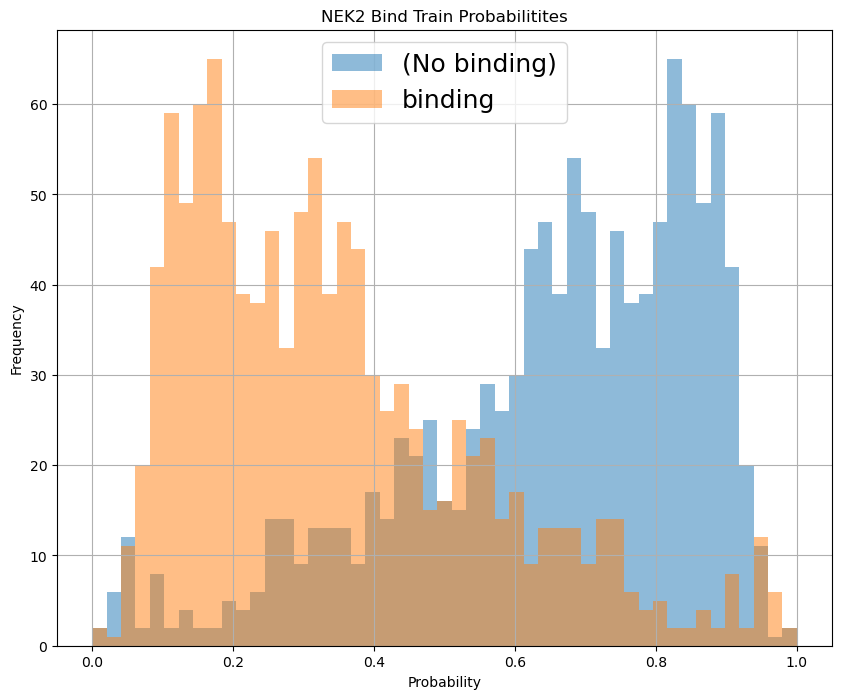

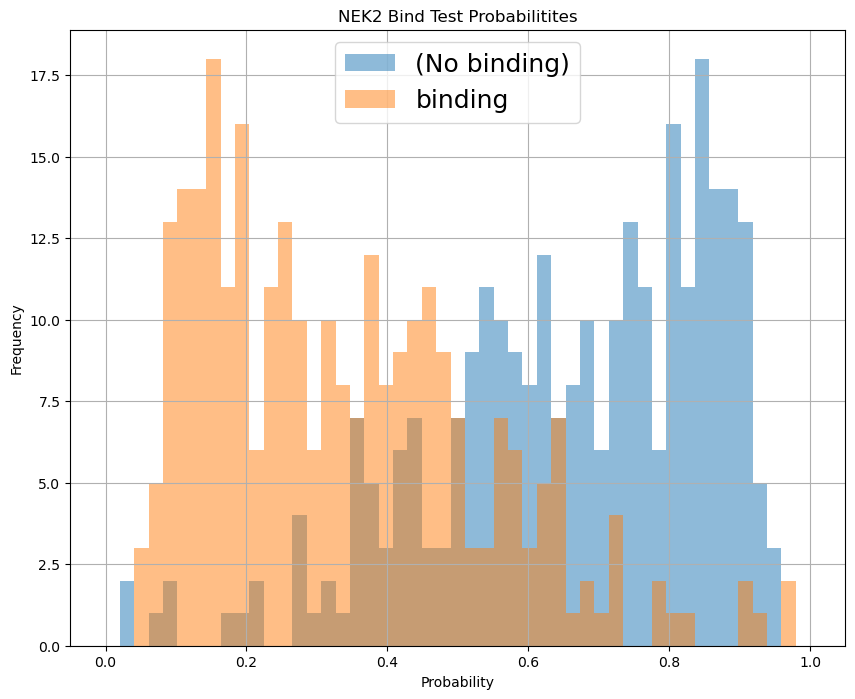

In [20]:
plot_prob(train_prob0, train_prob1, 'NEK2 Bind Train Probabilitites', 'binding')
plot_prob(test_prob0, test_prob1, 'NEK2 Bind Test Probabilitites', 'binding')

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 6.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


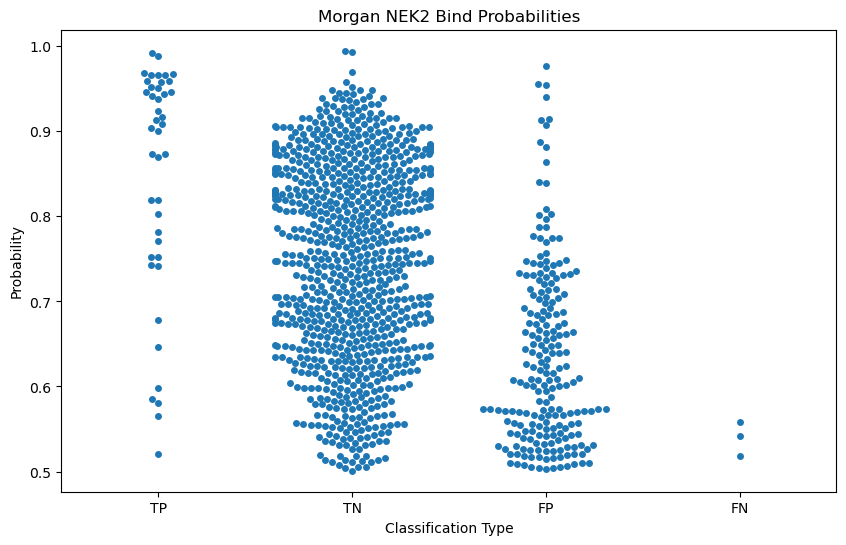

In [21]:
swarm_prob(brfc_bcw_best, train_x, train_y, 'Morgan NEK2 Bind Probabilities')

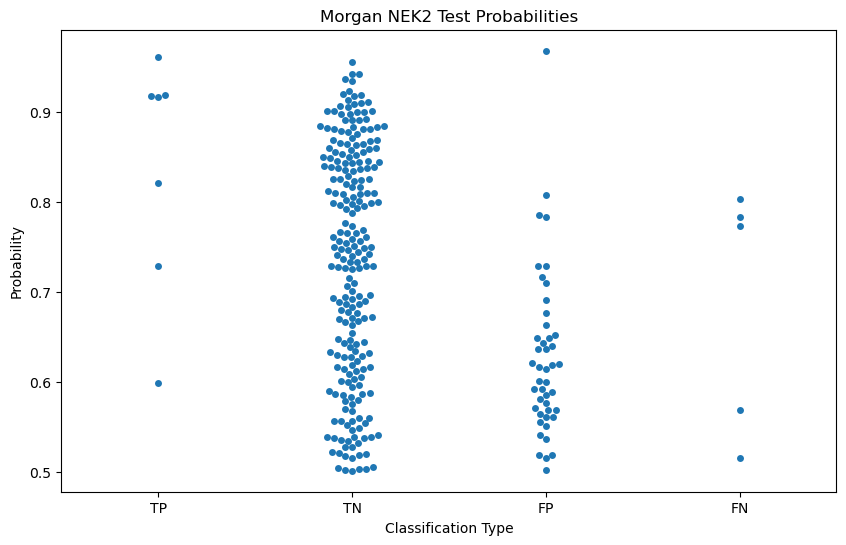

In [22]:
swarm_prob(brfc_bcw_best, test_x, test_y, 'Morgan NEK2 Test Probabilities')